In [11]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    folder_path = '/content/drive/My Drive/Colab Notebooks/TorchGMM'
    import os
    files = os.listdir(folder_path)
    print(files)
    os.chdir(folder_path)
except:
    pass

folder = 'plots/FMNIST'

In [12]:
import torch
import math
from torch import nn
from tqdm import tqdm
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.cm as cm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
if 'umap' not in globals():
    !pip install umap-learn
import umap
import time
from datetime import timedelta
from torch.distributions.multivariate_normal import MultivariateNormal

import utils
import utils.metrics
import utils.gmm
import utils.representation_layer
import importlib
importlib.reload(utils)
importlib.reload(utils.metrics)
importlib.reload(utils.gmm)
importlib.reload(utils.representation_layer)
from utils.metrics import ClusteringMetrics
from utils.representation_layer import RepresentationLayer
from utils.gmm import GaussianMixture

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    device = torch.device('cuda:0')
    torch.cuda.set_device(device)
    print('Using device:', torch.cuda.get_device_name(device))
    print(f"Allocated memory: {torch.cuda.memory_allocated(device)/1024**2} MB")
    print(f"Reserved memory: {torch.cuda.memory_reserved(device)/1024**2} MB")
    print(f"Total memory: {torch.cuda.get_device_properties(device).total_memory/1024**2} MB")

random_state = 0

print('Using device:', device)

Using device: NVIDIA GeForce RTX 4060 Laptop GPU
Allocated memory: 0.4580078125 MB
Reserved memory: 2.0 MB
Total memory: 7836.25 MB
Using device: cuda:0


Train dataset: 60000
Test dataset: 10000
Image shape: torch.Size([1, 28, 28])
Image size: 784
Plotting 10 images.


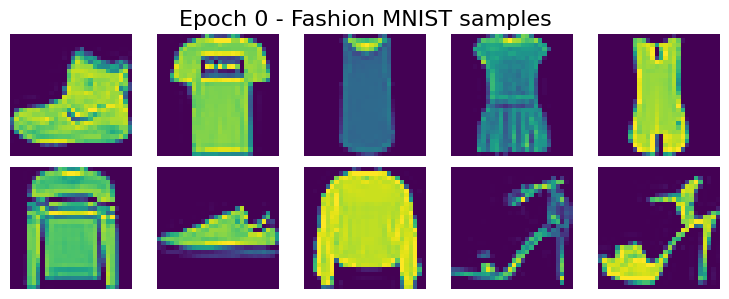

In [13]:
def plot_images(images, title, epoch, max_cols=10, cmap='gray_r'):
    if isinstance(images, torch.Tensor):
        images = [img.detach().cpu() for img in images]
    elif isinstance(images, list):
        images = [img.detach().cpu() if isinstance(img, torch.Tensor) else img for img in images]
    else:
        raise TypeError("Images should be a list or a torch.Tensor")

    print(f"Plotting {len(images)} images.")
    n_images = len(images)
    if n_images == 0:
        print("No images to plot.")
        return
    
    if n_images <= 5:
        n_cols = n_images
    elif n_images <= 10:
        n_cols = 5
    else:
        n_cols = min(max_cols, n_images)
    n_rows = math.ceil(n_images / n_cols)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = images[i].squeeze()
        ax.imshow(img, cmap=cmap, interpolation='nearest')
        ax.axis('off')
    
    # Turn off any unused subplots
    for i in range(n_images, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f'Epoch {epoch} - {title}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)  # Adjust to make room for suptitle
    plt.savefig(f'{folder}/{title.replace(" ", "_").lower()}_epoch_{epoch}.pdf', format='pdf', dpi=400)
    plt.show()

# Load a small subset of the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

class IndexedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        data, target = self.dataset[index]
        return index, data, target

indexed_train_dataset = IndexedDataset(train_dataset)
indexed_test_dataset = IndexedDataset(test_dataset)

train_loader = DataLoader(indexed_train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(indexed_test_dataset, batch_size=128, shuffle=True)

print('Train dataset:', len(indexed_train_dataset))
print('Test dataset:', len(indexed_test_dataset))

# print shape of an image
print('Image shape:', train_dataset[0][0].shape)
# print total number of pixels in an image
print('Image size:', train_dataset[0][0].numel())

all_labels = torch.tensor([label for _, _, label in indexed_train_dataset], device=device)

# Plot some images
plot_images([train_dataset[i][0] for i in range(10)], 'Fashion MNIST samples', 0, cmap='viridis')

In [14]:
def fourier_feature_mapping(x, B):
    if B is None:
        return x
    else:
        B = B.to(x.device)
        x_proj = (2. * np.pi * x) @ B.T
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class ConvDecoder(nn.Module):
    def __init__(self, latent_dim, fourier_dim=None, scale=1.0, dropout=0.1, batch_norm=False):
        super(ConvDecoder, self).__init__()
        
        # Create the random Fourier feature matrix
        self.B = None
        if fourier_dim:
            self.B = torch.randn(fourier_dim, latent_dim) * scale

        # Linear layers construction
        layers = [nn.Linear(2 * fourier_dim if fourier_dim else latent_dim, 128)]
        if batch_norm:
            layers.append(nn.BatchNorm1d(128))
        layers += [
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 128 * 7 * 7)
        ]
        if batch_norm:
            layers.append(nn.BatchNorm1d(128 * 7 * 7))
        layers += [
            nn.SiLU(),
            nn.Dropout(dropout)
        ]

        self.decoder_lin = nn.Sequential(*layers)

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(128, 7, 7))

        # Convolutional layers construction
        conv_layers = [
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        ]
        if batch_norm:
            conv_layers.append(nn.BatchNorm2d(64))
        conv_layers += [
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        ]
        if batch_norm:
            conv_layers.append(nn.BatchNorm2d(32))
        conv_layers += [
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        ]

        self.conv_layers = nn.Sequential(*conv_layers)


    def forward(self, x):
        # Apply Fourier feature mapping if B is defined
        if self.B is not None:
            x = fourier_feature_mapping(x, self.B)
        
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.conv_layers(x)
        return x

In [15]:
# Loss plot function
def plot_loss(gmm_train_losses, gmm_test_losses, recon_train_losses, recon_test_losses, epoch):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # GMM Loss Plot
    axes[0].plot(gmm_train_losses, label='Train Loss', color='red')
    axes[0].plot(gmm_test_losses, label='Test Loss', color='green')
    axes[0].set_title('GMM Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Reconstruction Loss Plot
    axes[1].plot(recon_train_losses, label='Train Loss', color='red')
    axes[1].plot(recon_test_losses, label='Test Loss', color='green')
    axes[1].set_title('Reconstruction Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    # Total Loss Plot
    total_train_losses = [gmm_train_losses[i] + recon_train_losses[i] for i in range(len(gmm_train_losses))]
    total_test_losses = [gmm_test_losses[i] + recon_test_losses[i] for i in range(len(gmm_test_losses))]
    axes[2].plot(total_train_losses, label='Train Loss', color='red')
    axes[2].plot(total_test_losses, label='Test Loss', color='green')
    axes[2].set_title('Total Loss')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()

    plt.suptitle(f'Losses at Epoch {epoch}', size=16)
    plt.tight_layout()
    plt.savefig(f'{folder}/losses_epoch_{epoch}.pdf', format='pdf', dpi=400)
    plt.show()


def plot_latent_space_visualizations(representations, labels, n_features, epoch, fraction=0.05, s=1, alpha=1, perplexity=20, gmm_means=None):
    n_samples = int(fraction * representations.shape[0])
    subset_indices = torch.randperm(representations.shape[0])[:n_samples]
    representations_subset = representations[subset_indices].cpu().numpy()
    labels_subset = labels[subset_indices].cpu().numpy()
    
    color_codes = ['#a50026', '#d73027', '#f46d43', '#fdae61', '#fee08b',
                   '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837']
    loc = 'upper right'
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    if n_features == 2:
        # Plot first vs second component directly
        axes[0, 0].set_title('Latent Space (First vs Second Component)')
        for digit in range(10):
            digit_mask = labels_subset == digit
            axes[0, 0].scatter(representations_subset[digit_mask, 0], representations_subset[digit_mask, 1],
                               color=color_codes[digit], alpha=alpha, label=f'{digit}', s=s)
        if gmm_means is not None:
            axes[0, 0].scatter(gmm_means[:, 0], gmm_means[:, 1], marker='x', color='black', s=70, label='GMM Means')
        axes[0, 0].legend(loc=loc)
    else:
        # PCA
        pca = PCA(n_components=2)
        representations_pca = pca.fit_transform(representations_subset)
        axes[0, 0].set_title('PCA')
        for digit in range(10):
            digit_mask = labels_subset == digit
            axes[0, 0].scatter(representations_pca[digit_mask, 0], representations_pca[digit_mask, 1],
                               color=color_codes[digit], alpha=alpha, label=f'{digit}', s=s)
        if gmm_means is not None:
            gmm_means_pca = pca.transform(gmm_means)
            axes[0, 0].scatter(gmm_means_pca[:, 0], gmm_means_pca[:, 1], marker='x', color='black', s=70, label='GMM Means')
        axes[0, 0].legend(loc=loc)

    # Kernel PCA
    kpca = KernelPCA(n_components=2, kernel='rbf')
    representations_kpca = kpca.fit_transform(representations_subset)
    for digit in range(10):
        digit_mask = labels_subset == digit
        axes[0, 1].scatter(representations_kpca[digit_mask, 0], representations_kpca[digit_mask, 1], 
                          color=color_codes[digit], alpha=alpha, label=f'{digit}', s=s)
    axes[0, 1].set_title('Kernel PCA')
    axes[0, 1].legend(loc=loc)
    
    # t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity)
    representations_tsne = tsne.fit_transform(representations_subset)
    for digit in range(10):
        digit_mask = labels_subset == digit
        axes[1,0].scatter(representations_tsne[digit_mask, 0], representations_tsne[digit_mask, 1], 
                          color=color_codes[digit], alpha=alpha, label=f'{digit}', s=s)
    axes[1,0].set_title('t-SNE')
    axes[1,0].legend(loc=loc)
    
    # UMAP
    umap_model = umap.UMAP(n_components=2)
    representations_umap = umap_model.fit_transform(representations_subset)
    for digit in range(10):
        digit_mask = labels_subset == digit
        axes[1,1].scatter(representations_umap[digit_mask, 0], representations_umap[digit_mask, 1], 
                          color=color_codes[digit], alpha=alpha, label=f'{digit}', s=s)
    axes[1,1].set_title('UMAP')
    axes[1,1].legend(loc=loc)
    
    plt.suptitle(f'Latent Space Visualizations at Epoch {epoch}', size=16)
    plt.tight_layout()
    plt.savefig(f'{folder}/latent_space_epoch_{epoch}.pdf', format='pdf', dpi=400)
    plt.show()

def select_random_images(data_loader, device, num_images=10):
    images = []
    labels = []
    indices = []
    for batch_indices, x, batch_labels in data_loader:
        for idx, img, label in zip(batch_indices, x, batch_labels):
            images.append(img.to(device))
            labels.append(label.to(device))
            indices.append(idx.to(device))
            if len(images) == num_images:
                break
        if len(images) == num_images:
            break
    images = torch.stack(images)
    labels = torch.stack(labels)
    indices = torch.stack(indices)
    return images, labels, indices

import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_images(images, title, epoch, max_cols=10, cmap='gray_r'):
    if isinstance(images, torch.Tensor):
        images = [img.detach().cpu() for img in images]
    elif isinstance(images, list):
        images = [img.detach().cpu() if isinstance(img, torch.Tensor) else img for img in images]
    else:
        raise TypeError("Images should be a list or a torch.Tensor")

    print(f"Plotting {len(images)} images.")
    n_images = len(images)
    if n_images == 0:
        print("No images to plot.")
        return
    
    if n_images <= 5:
        n_cols = n_images
    elif n_images <= 10:
        n_cols = 5
    else:
        n_cols = min(max_cols, n_images)
    n_rows = math.ceil(n_images / n_cols)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = images[i].squeeze()
        ax.imshow(img, cmap=cmap, interpolation='nearest')
        ax.axis('off')
    
    # Turn off any unused subplots
    for i in range(n_images, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f'Epoch {epoch} - {title}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)  # Adjust to make room for suptitle
    plt.savefig(f'{folder}/{title.replace(" ", "_").lower()}_epoch_{epoch}.pdf', format='pdf', dpi=400)
    plt.show()




def plot_gmm_results(X, gmm, epoch):
    X = X.detach().cpu().numpy()
    log_probs = gmm.score_samples(torch.from_numpy(X).to(gmm.device)).cpu().numpy()
    y_pred = gmm.predict(torch.from_numpy(X).to(gmm.device)).cpu().numpy()
    
    n_components = gmm.n_components
    cmap = plt.get_cmap('tab20', n_components)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot 1: Per-Sample Log Likelihood
    scatter = axs[0].scatter(X[:, 0], X[:, 1], c=log_probs, cmap='viridis', s=1, alpha=0.2)
    axs[0].set_title('Per-Sample Log-Likelihood')
    axs[0].set_xlabel('Feature 1')
    axs[0].set_ylabel('Feature 2')
    cbar = fig.colorbar(scatter, ax=axs[0])
    cbar.set_label('Log-Likelihood')
    
    # Plot 2: Predicted Cluster Labels
    scatter = axs[1].scatter(X[:, 0], X[:, 1], c=y_pred, cmap=cmap, s=1, alpha=0.2)
    axs[1].set_title('Predicted Cluster Labels')
    axs[1].set_xlabel('Feature 1')
    axs[1].set_ylabel('Feature 2')
    cbar = fig.colorbar(scatter, ax=axs[1], ticks=range(n_components))
    cbar.set_label('Cluster Label')
    
    plt.suptitle(f'GMM Results at Epoch {epoch}', size=16)
    plt.tight_layout()
    plt.savefig(f'{folder}/gmm_results_epoch_{epoch}.pdf', format='pdf', dpi=400)
    plt.show()


def plot_gmm_generated_samples(gmm, epoch, n_samples=1000):
    # Generate samples from the GMM
    gmm_samples, gmm_labels = gmm.sample(n_samples=n_samples)
    gmm_samples = gmm_samples.cpu().numpy()
    gmm_labels = gmm_labels.cpu().numpy()
    
    n_components = gmm.n_components
    cmap = plt.get_cmap('tab20', n_components)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Left Plot: Per-Sample Log Likelihood
    log_probs = gmm.score_samples(torch.from_numpy(gmm_samples).to(gmm.device))
    scatter = axs[0].scatter(gmm_samples[:, 0], gmm_samples[:, 1], c=log_probs.cpu().numpy(), cmap='viridis', s=10, alpha=.5)
    axs[0].set_title('Per-Sample Log-Likelihood (Generated Samples)')
    axs[0].set_xlabel('Feature 1')
    axs[0].set_ylabel('Feature 2')
    cbar = fig.colorbar(scatter, ax=axs[0])
    cbar.set_label('Log-Likelihood')
    
    # Right Plot: Cluster Labels
    scatter = axs[1].scatter(gmm_samples[:, 0], gmm_samples[:, 1], c=gmm_labels, cmap=cmap, s=10, alpha=.5)
    axs[1].set_title('Generated Samples with Cluster Labels')
    axs[1].set_xlabel('Feature 1')
    axs[1].set_ylabel('Feature 2')
    cbar = fig.colorbar(scatter, ax=axs[1], ticks=range(n_components))
    cbar.set_label('Cluster Label')
    
    plt.suptitle(f'GMM Generated Samples at Epoch {epoch}', size=16)
    plt.tight_layout()
    plt.savefig(f'{folder}/gmm_generated_samples_epoch_{epoch}.pdf', format='pdf', dpi=400)
    plt.show()





def plot_gmm_component_probabilities(X, gmm, title_prefix, epoch):
    X = X.detach().cpu().numpy()
    probs = gmm.predict_proba(torch.from_numpy(X).to(gmm.device)).detach().cpu().numpy()
    n_components = gmm.n_components
    n_cols = 2
    n_rows = (n_components + 1) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
    axs = axs.flatten()
    
    for k, ax in enumerate(axs):
        if k < n_components:
            prob_k = probs[:, k]
            scatter = ax.scatter(X[:, 0], X[:, 1], c=prob_k, cmap='viridis', s=1, alpha=0.2)
            ax.set_title(f'Component {k+1} Probability')
            ax.set_xlabel('Feature 1')
            ax.set_ylabel('Feature 2')
            cbar = fig.colorbar(scatter, ax=ax)
            cbar.set_label('Probability')
        else:
            ax.axis('off')
    
    fig.suptitle(f"{title_prefix} Probability Distributions Across GMM Components at Epoch {epoch}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'{folder}/gmm_component_probabilities_epoch_{epoch}.pdf', format='pdf', dpi=400)
    plt.show()

def get_covariance_matrix(gmm, n):
    if gmm.covariance_type == 'full':
        cov = gmm.covariances_[n].detach().cpu().numpy()
    elif gmm.covariance_type == 'tied':
        cov = gmm.covariances_.detach().cpu().numpy()
    elif gmm.covariance_type == 'diag':
        cov = np.diag(gmm.covariances_[n].detach().cpu().numpy())
    elif gmm.covariance_type == 'spherical':
        cov = np.eye(gmm.n_features) * gmm.covariances_[n].detach().cpu().numpy()
    else:
        raise ValueError("Unsupported covariance type")
    return cov

def plot_covariance_ellipse(ax, mean, cov, n_std=1, **kwargs):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ellipse)


def plot_gmm_contours(gmm, X, epoch):
    X = X.detach().cpu().numpy()
    n_components = gmm.n_components
    colors = plt.cm.get_cmap('tab20', n_components)
    means = gmm.means_.detach().cpu().numpy()
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # First Plot
    ax = axs[0]
    ax.scatter(X[:, 0], X[:, 1], c='black', s=1, zorder=1, alpha=0.2, label='Representations')
    ax.scatter(means[:, 0], means[:, 1], marker='x', color='red', s=50, zorder=2, label='GMM Means')
    
    for n in range(n_components):
        mean = means[n]
        cov = get_covariance_matrix(gmm, n)
        plot_covariance_ellipse(ax, mean, cov, edgecolor='red', linestyle='--', zorder=3, facecolor='none')
    
    ax.set_title('GMM Means and Covariances')
    ax.legend()
    ax.axis('equal')
    
    # Second Plot
    ax = axs[1]
    for n in range(n_components):
        mean = means[n]
        cov = get_covariance_matrix(gmm, n)
        std = 1
        plot_covariance_ellipse(ax, mean, cov, n_std=std, edgecolor=colors(n), facecolor=colors(n, alpha=0.5), zorder=2)
    
    ax.set_title('GMM Components')
    ax.axis('equal')
    plt.suptitle(f'Gaussian Mixture at Epoch {epoch}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{folder}/gmm_contours_epoch_{epoch}.pdf', format='pdf', dpi=400)
    plt.show()


In [16]:
def train_loop(train_loader, test_loader, model, gmm, rep, test_rep, optimizers, n_epochs, first_epoch_gmm=1, refit_gmm_interval=None, plot_step=None, plot_skip=0, lambda_gmm=1.0, n_images = 20, metrics_list=None):
    assert first_epoch_gmm >= 1, "First epoch for GMM training should be at least 1." 
    start_time = time.time()
    
    model_optimizer, rep_optimizer, testrep_optimizer = optimizers

    train_losses = []
    test_losses = []
    gmm_train_losses = []
    gmm_test_losses = []
    recon_train_losses = []
    recon_test_losses = []

    # Select a fixed set of random images for visualization
    fixed_train_img, fixed_train_labels, fixed_train_indices = select_random_images(train_loader, device, num_images=n_components)
    fixed_test_img, fixed_test_labels, fixed_test_indices = select_random_images(test_loader, device, num_images=n_components)

    for epoch in range(1, n_epochs + 1):
        epoch_start_time = time.time()
        
        train_losses.append(0)
        test_losses.append(0)
        gmm_train_losses.append(0)
        gmm_test_losses.append(0)
        recon_train_losses.append(0)
        recon_test_losses.append(0)

        # Training loop
        rep_optimizer.zero_grad()
        for i, (index, x, labels_batch) in enumerate(train_loader):
            model_optimizer.zero_grad()

            x, index, labels_batch = x.to(device), index.to(device), labels_batch.to(device)
            z = rep(index)
            y = model(z)
            recon_loss_x = F.binary_cross_entropy(y, x, reduction='sum')

            if epoch < first_epoch_gmm:
                gmm_error = torch.tensor(0.0, device=device)
                loss = recon_loss_x
            else:
                gmm_error = -lambda_gmm * torch.mean(gmm.score_samples(z))
                loss = recon_loss_x + gmm_error

            loss.backward()
            model_optimizer.step()

            train_losses[-1] += loss.item() * x.size(0)
            gmm_train_losses[-1] += gmm_error.item() * x.size(0)
            recon_train_losses[-1] += recon_loss_x.item()

        rep_optimizer.step()

        # Testing loop
        testrep_optimizer.zero_grad()
        for i, (index, x, _) in enumerate(test_loader):
            x, index = x.to(device), index.to(device)
            z = test_rep(index)
            y = model(z)
            recon_loss_x = F.binary_cross_entropy(y, x, reduction='sum')
            if epoch < first_epoch_gmm:
                gmm_error = torch.tensor(0.0, device=device)
                loss = recon_loss_x
            else:
                gmm_error = -lambda_gmm * torch.mean(gmm.score_samples(z))
                loss = recon_loss_x + gmm_error
            
            loss.backward()

            test_losses[-1] += loss.item() * x.size(0)
            gmm_test_losses[-1] += gmm_error.item() * x.size(0)
            recon_test_losses[-1] += recon_loss_x.item()

        testrep_optimizer.step()

        if epoch == first_epoch_gmm:
            with torch.no_grad():
                representations = rep.z.detach().to(device)
                gmm.fit(representations, max_iter=100)
        
        elif epoch > first_epoch_gmm:
            with torch.no_grad():
                representations = rep.z.detach().to(device)
                if refit_gmm_interval and epoch % refit_gmm_interval == 0:
                    gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type=covariance_type, init_params=init_params, device=device)
                    gmm.fit(representations, max_iter=100)
                else:
                    gmm.fit(representations, max_iter=10, warm_start=True)

        # Average the losses
        train_losses[-1] /= len(train_loader.dataset)
        test_losses[-1] /= len(test_loader.dataset)
        gmm_train_losses[-1] /= len(train_loader.dataset)
        gmm_test_losses[-1] /= len(test_loader.dataset)
        recon_train_losses[-1] /= len(train_loader.dataset)
        recon_test_losses[-1] /= len(test_loader.dataset)

        # Timing calculations
        epoch_time = time.time() - epoch_start_time
        total_time_elapsed = time.time() - start_time
        avg_epoch_time = total_time_elapsed / epoch
        remaining_epochs = n_epochs - epoch
        estimated_time_left = avg_epoch_time * remaining_epochs
        estimated_finish_time = start_time + total_time_elapsed + estimated_time_left

        print(f"Epoch {epoch}/{n_epochs} - GMM Loss: {gmm_train_losses[-1]:.4f} / {gmm_test_losses[-1]:.4f} - "
              f"Recon Loss: {recon_train_losses[-1]:.4f} / {recon_test_losses[-1]:.4f} - "
              f"GMM Convergence: {gmm.converged_} ({gmm.n_iter_+1}) - "
              f"TpE: {timedelta(seconds=int(epoch_time))} - "
              f"RT: {timedelta(seconds=int(estimated_time_left))} - "
              f"ETA: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(estimated_finish_time))}")        

        if (plot_step and epoch % plot_step == 0 and epoch > plot_skip) or epoch == n_epochs:
            model.eval()
            with torch.no_grad():
                # Plot the losses
                plot_loss(gmm_train_losses, gmm_test_losses, recon_train_losses, recon_test_losses, epoch)

                # Get representations and labels
                representations = rep.z.detach()
                test_representations = test_rep.z.detach()
                labels = all_labels.cpu()
                with torch.no_grad():
                    recon_fixed_train = model(representations[:n_images]).squeeze().detach().cpu()
                    recon_fixed_test = model(test_representations[:n_images]).squeeze().detach().cpu()

                # Generate GMM means and samples
                sampled, sampled_labels = gmm.sample(n_components)
                sampled_imgs = [model(sample.unsqueeze(0)).squeeze().detach().cpu() for sample in sampled]
                gmm_means_imgs = [model(mean.unsqueeze(0)).squeeze().detach().cpu() for mean in gmm.means_]

                # Define titles and corresponding image sets
                titles = [
                    "Cluster Centers",
                    "New Samples",
                    "Reconstructed Train Images",
                    "Reconstructed Test Images",
                    "Original Train Images",
                    "Original Test Images"
                ]
                image_sets = [
                    gmm_means_imgs,
                    sampled_imgs,
                    recon_fixed_train[:n_components],  # Reconstructed Train Images
                    recon_fixed_test[:n_components],   # Reconstructed Test Images
                    fixed_train_img[:n_components],    # Original Train Images
                    fixed_test_img[:n_components]      # Original Test Images
                ]

                # Call the plotting function for each set
                for imgs, title in zip(image_sets, titles):
                    plot_images(imgs, title, epoch, cmap='viridis')  # Use 'gray_r' colormap

                if epoch == n_epochs:
                    plot_latent_space_visualizations(
                        representations, labels, n_features, epoch, fraction=1, s=1, alpha=1,
                        perplexity=20, gmm_means=gmm.means_.detach().cpu().numpy()
                    )
                else:
                    plot_latent_space_visualizations(
                        representations, labels, n_features, epoch, fraction=0.05, s=1, alpha=1,
                        perplexity=20, gmm_means=gmm.means_.detach().cpu().numpy()
                    )
                
                plot_gmm_results(representations, gmm, epoch)
                plot_gmm_generated_samples(gmm, epoch)

                X = rep.z.detach()
                true_labels = all_labels.cpu()

                # Evaluate clustering
                results = gmm.evaluate_clustering(X, true_labels=true_labels, metrics=metrics_list)

                # Print metrics
                for metric, score in results.items():
                    if metric != 'confusion_matrix' and metric != 'classification_report':
                        print(f"{metric}: {score}")

                # Confusion matrix
                cm = results['confusion_matrix']

                # Plot confusion matrix
                import seaborn as sns

                plt.figure(figsize=(8, 6))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.xlabel('Predicted Labels')
                plt.ylabel('True Labels')
                plt.title('Confusion Matrix')
                plt.savefig(f'{folder}/confusion_matrix_epoch_{epoch}.pdf', format='pdf', dpi=400)
                plt.show()

                
            model.train()

    model.eval()
    print('Training completed.')
    return model, gmm, rep, test_rep

metrics_list = [
    "rand_score",
    "adjusted_rand_score",
    "mutual_info_score",
    "normalized_mutual_info_score",
    "adjusted_mutual_info_score",
    "fowlkes_mallows_score",
    "homogeneity_score",
    "completeness_score",
    "v_measure_score",
    "purity_score",
    "classification_report",
    "confusion_matrix",
    "bic_score",
    "aic_score",
    # Exclude 'silhouette_score', 'davies_bouldin_index', 'calinski_harabasz_score', 'dunn_index'
]

# Initialize components
n_features = 5
n_components = 20
epochs = 300
plot_step = 50
plot_skip = 0
first_epoch_gmm = 1
refit_gmm_interval = 50
nsample = len(indexed_train_dataset)
nsample_test = len(indexed_test_dataset)
lambda_gmm = 1.0

# Adam Parameters
decoder_lr = 5e-3
rep_lr = 5e-2
decoder_weight_decay = 1e-5
decoder_betas = (0.9, 0.999)
rep_betas = (0.9, 0.999)
decoder_amsgrad = True
rep_amsgrad =False

# GMM Parameters
covariance_type = 'full'
init_params = 'kmeans'
    
# Decoder Parameters
dropout = 0.1
batch_norm = False
fourier_dim = None
scale = 1

gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type=covariance_type, init_params=init_params, device=device)

rep = RepresentationLayer(values=torch.randn(size=(nsample, n_features)).to(device))
test_rep = RepresentationLayer(values=torch.randn(size=(nsample_test, n_features)).to(device))

decoder = ConvDecoder(latent_dim=n_features, fourier_dim=fourier_dim, scale=scale, dropout=dropout, batch_norm=batch_norm).to(device)

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=decoder_lr, betas=decoder_betas, amsgrad=decoder_amsgrad, weight_decay=decoder_weight_decay)
rep_optimizer = torch.optim.Adam(rep.parameters(), lr=rep_lr, betas=rep_betas, amsgrad=rep_amsgrad)
testrep_optimizer = torch.optim.Adam(test_rep.parameters(), lr=rep_lr, betas=rep_betas, amsgrad=rep_amsgrad)

optimizers = [decoder_optimizer, rep_optimizer, testrep_optimizer]

decoder, gmm, rep, test_rep = train_loop(train_loader, test_loader, decoder, gmm, rep, test_rep, optimizers, n_epochs=epochs, first_epoch_gmm=first_epoch_gmm, refit_gmm_interval=refit_gmm_interval, plot_step=plot_step, plot_skip=plot_skip, lambda_gmm=lambda_gmm, metrics_list=metrics_list)

KeyboardInterrupt: 